해당 노트는 Hello World & Build with AI in Incheon 2025의 진행을 위하여 제작되었습니다.  
제작 : 박광석(모두의연구소, https://www.linkedin.com/in/andkspark)

해당 노트는 Autogen을 처음 접하시는 분들을 위한 튜토리얼입니다.  
참고 : https://microsoft.github.io/autogen/stable//user-guide/agentchat-user-guide/index.html

### Movie maker

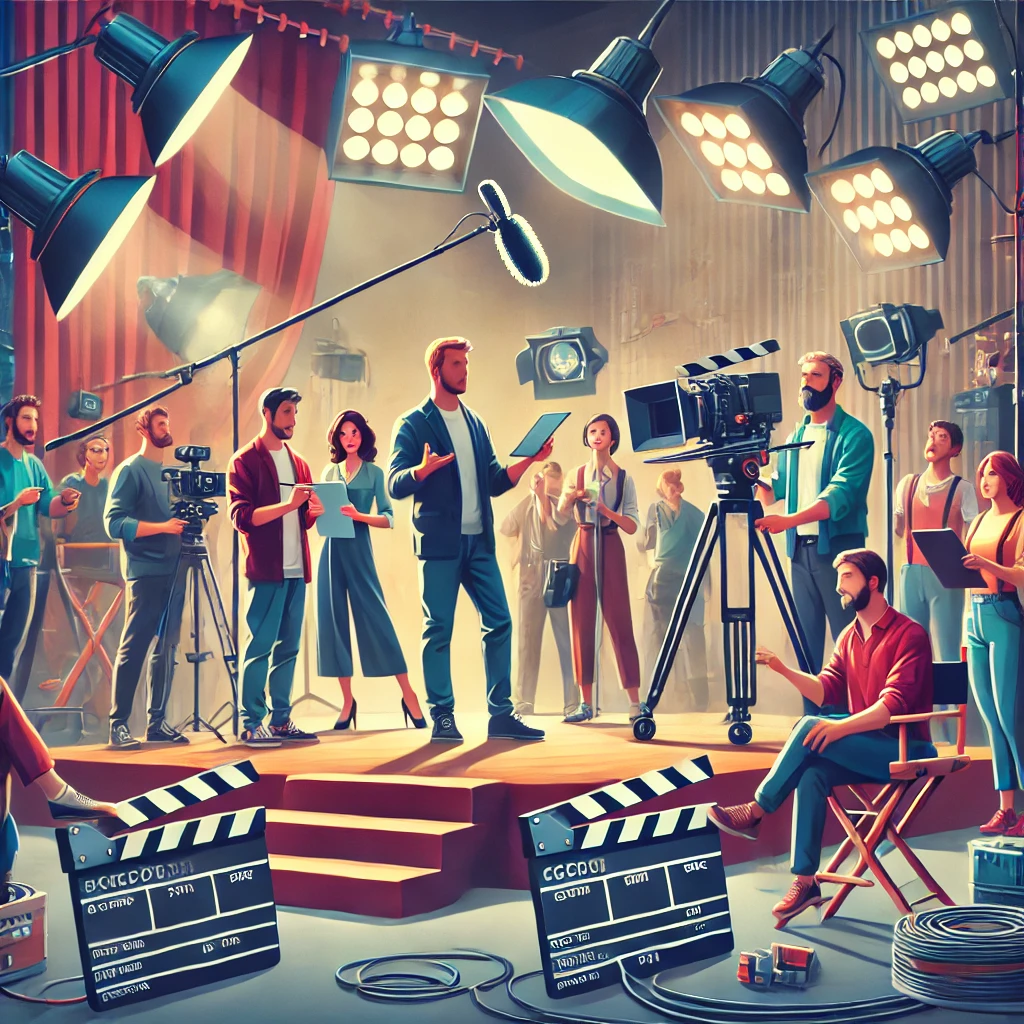

### Autogen 실습 : MovieAgent  
이번 실습은 Autogen을 사용하여 영화의 시나리오를 써보고, 콘티와 씬의 대표이미지를 생성하는 실습을 진행하겠습니다!  
영화 시나리오는 2025년 4월에 발표된 논문, MovieAgent(https://arxiv.org/pdf/2503.07314)
 의 시스템을 모방하여 생성하도록 해보죠 ! 사용자의 아이디어 한 줄에서 시나리오를 생성한 후, 씬을 여러개로 나누어 콘티를 작성한 후, 씬에 어울리는 이미지를 생성하는 것을 목표로 합니다. 우리에게 필요한 것은 멀티에이전트 시스템과 아이디어 한 줄, 그리고 시나리오에 참여할 캐릭터 정의입니다.

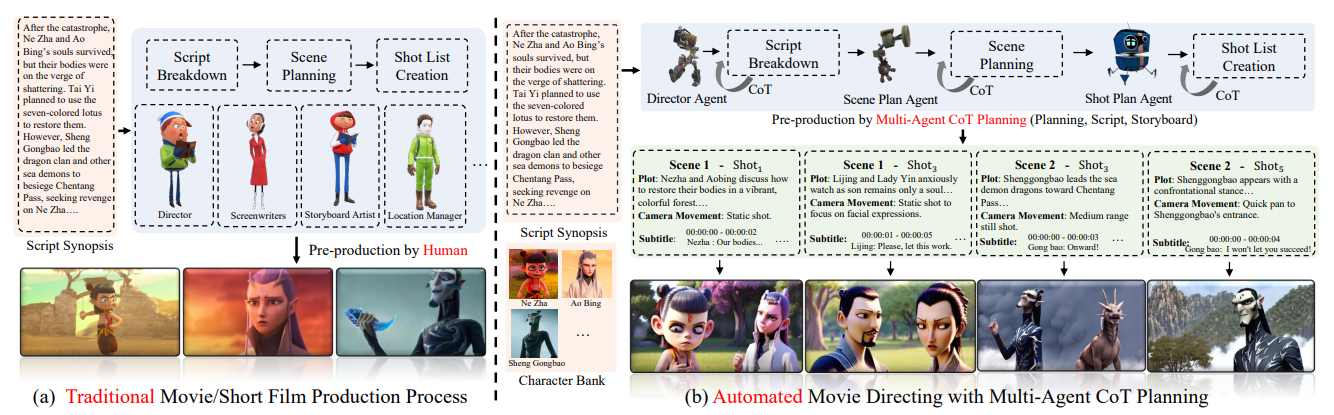

### Step 0 : 설치와 준비  
Autogen 설치 및 Gemini API 키를 등록하도록 합니다.

In [ ]:
!pip install autogen
!pip install -U "autogen-agentchat"
!pip install "autogen-ext[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.4/730.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.9/259.9 kB 12.0 MB/s eta 0:00:00


In [ ]:
GOOGLE_API_KEY =

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_ext.models.openai import OpenAIChatCompletionClient

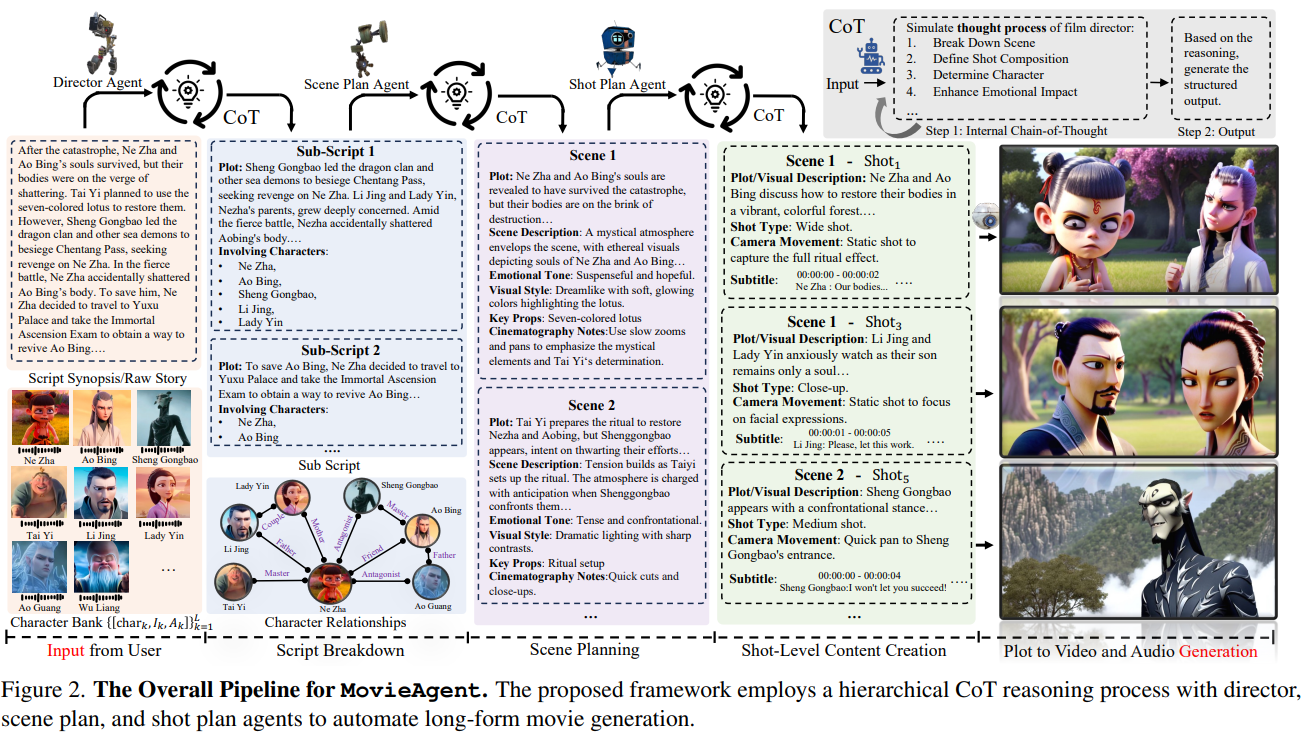

논문에서 각 에이전트간 커뮤니케이션을 한 방식입니다.
Director가 Character bank와 시나리오로부터 sub-script를 여러 개 제작한 다음, Scene plan agent가 sub-script를 바탕으로 shot을 여러개 기획합니다. 논문에서는 이 shot으로부터 영상을 직접 제작하게 됩니다.  
  
우리는 이 프로세스를 약간의 변형을 가하여 구현해보도록 하죠!  
저는 scenario writer, scene planner, storyboard artist를 차용했습니다.  
  
scenario writer는 간단한 아이디어와 character bank 로부터 이야기를 써내려갑니다.
scene planner는 시나리오를 sub-script로 나눕니다.  
storyboard artist는 sub-script로부터 분위기, 앵글, 화면의 설명등을 정의합니다.  
  
System prompt에 위 작업에 대한 내용과, Movie agent에서 제시한 포멧을 넣어 출력의 형태를 맞춥니다.

### Step 1 : 에이전트 시스템 메세지 작성  
각 에이전트에 적용할 시스템 메세지와 에이전트의 설명을 작성해보겠습니다.  
description 또한 에이전트 선언에 꼭 필요하니, 잘 기억해주세요!  

In [ ]:
system_message_scenario_writer = '''
you are a scenario writer.
YOUR ANSWER MUST BE TEXT ONLY, NEVER CONTAIN ANY IMAGE.
You must write a creative story from given idea and characters.
Break down the scripted to 3~5 sub-scripts.
a sub-script includes *Plot* and *Involving Characters*, and you must write *Plot* and select *Involving Characters* from given character bank.
'''

description_scenario_writer = "a creative scenario writer"

In [ ]:
system_message_scene_planner = '''
you are a scene planner.
YOUR ANSWER MUST BE TEXT ONLY, NEVER CONTAIN ANY IMAGE.
You must write a creative sub-script from given *Synopsis*.
Break down the Synopsis to 3~5 sub-scripts. a sub-script includes *Plot* and *Involving Characters*.

this is the example what you follow the format

Plot: Sheng Gongbao led the dragon clan and
other sea demons to besiege Chentang Pass,
seeking revenge on Ne Zha. Li Jing and Lady Yin,
Nezha's parents, grew deeply concerned. Amid
the fierce battle, Nezha accidentally shattered
Aobing's body.…
Involving Characters:
• Ne Zha,
• Ao Bing,
• Sheng Gongbao,
• Li Jing,
• Lady Yin
'''

description_scene_planner = "a creative scene planner"

In [ ]:
system_message_storyboard_artist = '''
you are a storyboard artist.
YOUR ANSWER MUST BE TEXT ONLY, NEVER CONTAIN ANY IMAGE. YOUR OUTPUT MUST BE LESS THAN 3900 CHARACTERS INCLUDING BLANK.
You must evaluate the given script, and write a creative scene from given *sub-script*.
Break down the Sub-script to 3~5 Scenes.
a sub-script includes *Plot* ,*Scene Description*, *Emotional tone*, *Visual style*, *Key props* and Involving Characters and Cinematography Notes*

This is the example what you follow the format

Plot: Ne Zha and Ao Bing's souls are
revealed to have survived the catastrophe,
but their bodies are on the brink of
destruction…
Scene Description: A mystical atmosphere
envelops the scene, with ethereal visuals
depicting souls of Ne Zha and Ao Bing…
Emotional Tone: Suspenseful and hopeful.
Visual Style: Dreamlike with soft, glowing
colors highlighting the lotus.
Key Props: Seven-colored lotus
Cinematography Notes:Use slow zooms
and pans to emphasize the mystical
elements and Tai Yi‘s determination.

You must ensure that the final sub-scripts are integrated and complete.
YOUR FINAL RESPONSE MUST BE THE COMPLETE STORY. When the story is complete and all perspectives are integrated, you can respond with TERMINATE .
'''

description_storyboard_artist = "a creative storyboard artist"

### Q1. 모델 클라이언트 정의  
gemini 를 사용하는 모델 클라이언트를 정의해주세요!  
들어가야 하는 변수를 꼼꼼히 챙겨주세요!  

In [ ]:
#코드를 작성해주세요




### Q2. 에이전트 정의  
위에서 선언한 모델 클라이언트를 사용하는 어시스턴트들을 정의해주세요!  
scenario writer, scene planner, storyboard artist 가 필요합니다  

In [ ]:
# 코드를 작성해주세요





### Step 4.  아이디어와 캐릭터 정하기  
여러분들의 아이디어와 캐릭터를 정해주세요~  
저는 로미오와 줄리엣으로 하겠습니다  

In [ ]:
idea = '''
At the night, romeo wants to confess his mind to Juliette. Juliette is about to sleep at her room on 2nd story of her castle, and the room has a big window
'''

In [ ]:
character_bank = '''

Romeo : Romeo is the very embodiment of romance. Bold and passionate, he wears his heart on his sleeve.
His love for Juliet is so deep, he would face death itself for her.
Yet, fate has cursed their love—his family and Juliet’s are sworn enemies, locked in bitter hatred.

Juliet: Juliet fell for Romeo in an instant, as if struck by lightning.
She longs for a chance to speak with him, to share whispers beneath the moonlight.
But destiny is cruel—the blood feud between her family and Romeo’s keeps them worlds apart.

Guard: The vigilant protector, tirelessly patrolling to shield Juliet from lurking dangers and unseen threats.

'''

### Q3. 그룹챗 선언  
그룹쳇에는 위에 선언한 세 개의 에이전트가 들어가야 합니다!  
챗 종료를 관리하기 위한 termination을 정의하고 시작해보죠

In [ ]:
from autogen_agentchat.teams import RoundRobinGroupChat

In [ ]:
#코드를 작성해주세요





In [ ]:
# 여러 번 그룹챗을 수행할 경우, 꼭 위의 그룹챗 선언 전에 해당 문구를 먼저 실행해주시기 바랍니다
# await group_chat.reset()

### Q4. 스트림 실행하기  
콘솔에서 아래 선언한 스트림을 실행해보세요!  
결과를 result 변수로 받아 추후 작업을 수행할 수 있습니다.

In [ ]:
from autogen_agentchat.ui import Console

In [ ]:
movie_task = f"write down a great scenario with given idea : {idea} and characters : {character_bank}"

In [1]:
#코드를 작성해주세요






실행 결과 중, storyboard_artist 의 출력만 확인해봅시다

In [ ]:
for message in result.messages:
  if message.source == "storyboard_artist_agent":
    print(message.content)

**Sub-Script 1**

*Plot:* Romeo bribes a kitchen boy for information about Juliet's room and patrol routes. He learns of a blind spot in the guard's route, a shadowed alcove offering temporary concealment.

*Scene Description:* Dark, grimy kitchen. Whispered conversation.

*Emotional Tone:* Tense, secretive.

*Visual Style:* Low lighting, close-ups on faces.

*Key Props:* Coins, map sketched on parchment.

*Involving Characters:* Romeo, Kitchen Boy, Guard (mentioned)

*Cinematography Notes:* Use shallow focus to emphasize Romeo's urgency.

**Sub-Script 2**

*Plot:* Romeo uses the blind spot, navigating the maze-like garden under the cover of a cloudy sky. Every rustle of leaves sounds like an alarm. He reaches the base of Juliet's balcony, heart pounding.

*Scene Description:* Overgrown garden, obscured by shadows. High walls.

*Emotional Tone:* Anxious, determined.

*Visual Style:* Silhouette against the castle walls. Use long shadows.

*Key Props:* None

*Involving Characters:* Romeo

안타깝게도, 일시적으로 autogen이 이미지 생성 모델 (dall-e-3 등) 을 지원하지 않습니다.   
위에서 Storyboard writer 가 작성한 컨텐츠를 openai 의 클라이언트를 사용해서 그려볼게요!  
아래 구문을 실행해서, 결과를 확인해주세요~  
결과를 확인하기 전에, 연사에게 OPENAI_API_KEY를 발급받으시기 바랍니다  

In [ ]:
def get_subscripts(result):
  for message in result.messages:
    if message.source == "storyboard_artist_agent":
      return message.content

In [ ]:
import openai

In [ ]:
OPENAI_API_KEY =

In [ ]:
test_client = openai.OpenAI(
    api_key = OPENAI_API_KEY,
    )

prompt = f"draw images describe subscripts in {get_subscripts(result)} in comic book format. Each frame should describes each sub-script and main characters of each plot must be shown in corresponding frame"

response = test_client.images.generate(
  model="dall-e-3",
  prompt=prompt,
  size="1024x1024",
  quality="hd",
  n=1,
)

In [2]:
# 주석을 풀어 답변을 확인하세요!
#response

아래 URL을 눌러보세요. 상상했던 그림이 나왔나요?  
프롬프트를 수정하시면서 원하는 그림을 완성하시기 바랍니다!  

2025년 3월 말 업데이트 이후로 일시적으로 autogen / agentchat 이미지 생성 모델 (dall-e-3 등) 을 지원하지 않습니다.   
다른 에이전트의 선언 및 활용처럼 group chat에서 피드백을 받으며 고품질의 이미지를 생성할 수 있으니, 추후에 꼭 시도해보시기 바랍니다!  
수고하셨습니다!